In [22]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import*
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, BooleanType, DoubleType
import pyinputplus as pyip

import pymysql
import pandas as pd
import matplotlib.pyplot as plt
import pandas.io.sql as psql

import seaborn as sns

In [23]:
# Initialize spark session

spark = SparkSession.builder.master("local").appName('Credit_card.com').getOrCreate()

In [24]:
# connection with database (Read data from database)

connection = pymysql.connect(
    host='localhost',
    user='root',
    password='password',
    database='creditcard_capstone'
)

In [25]:
# Data Visualization plots for Loan Application Data and Customer Data

# Queries for customer Visualization

def get_credit_card_df():
    query1 = "SELECT * FROM cdw_sapp_credit_card"
    return psql.read_sql(query1, con=connection)

def get_customer_df():
    query2 = "SELECT * FROM cdw_sapp_customer"
    return psql.read_sql(query2, con=connection)

def get_highest_transaction():

    query3 = "SELECT cust.FIRST_NAME,cust.LAST_NAME,cust.MIDDLE_NAME,cust.SSN,cust.CUST_EMAIL,cc.CUST_SSN,cc.TRANSACTION_VALUE" \
          " FROM cdw_sapp_customer cust " \
          "JOIN cdw_sapp_credit_card cc ON cust.SSN = cc.CUST_SSN "
    return psql.read_sql(query3, con=connection)

# Query for Loan data visualization

def get_loan_api_df():
    query4 = "SELECT * FROM CDW_SAPP_loan_application"
    return psql.read_sql(query4, con=connection)

+-------------+-------------------------+-------+
|self_employed|count(application_status)|Percent|
+-------------+-------------------------+-------+
|           No|                      301|  86.74|
|          Yes|                       46|  13.26|
+-------------+-------------------------+-------+

self_employed                 object
count(application_status)      int64
Percent                      float64
dtype: object


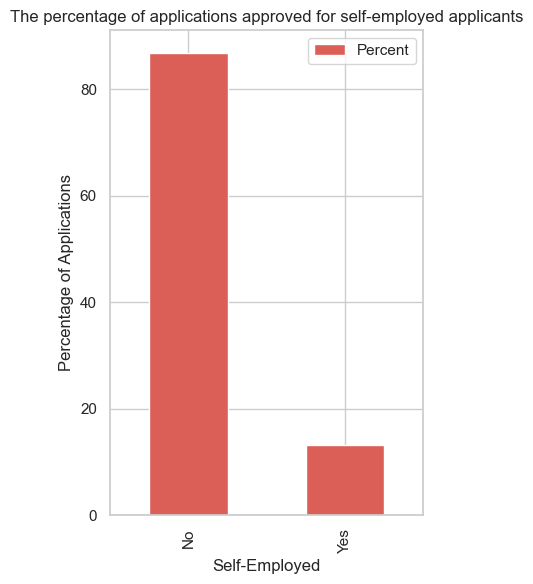

In [26]:
# 5.1 Find and plot the percentage of applications approved for self-employed applicants.

def self_employed_5_1(pandas_df):
 
    query = "(SELECT self_employed, count(application_status), \
                (round(count(application_status)/(SELECT COUNT(Application_ID) FROM cdw_sapp_loan_application \
                WHERE application_status = 'Y')*100, 2) ) as Percent \
                FROM cdw_sapp_loan_application \
                WHERE Application_status = 'Y' \
                GROUP BY self_employed, application_status) as b"

    spark_df = spark.read.format("jdbc") \
              .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
              .option("user", "root") \
              .option("password", "password") \
              .option("dbtable", query) \
              .load()

    spark_df.show()
   
    pandas_df = spark_df.toPandas()
    
    pandas_df['Percent'] = pandas_df['Percent'].astype('float')
    print(pandas_df.dtypes)

    pandas_df.plot(kind='bar', x='self_employed', y='Percent', figsize=(4,6))
    plt.title('The percentage of applications approved for self-employed applicants')
    plt.xlabel('Self-Employed')
    plt.ylabel('Percentage of Applications')
    sns.set_theme(style="whitegrid", palette="hls")
    plt.show()

self_employed_5_1('pandas_df')

+------------------+------------------+-------+
|application_status|count_applications|Percent|
+------------------+------------------+-------+
|                 N|                87|  28.43|
|                 Y|               219|  71.57|
+------------------+------------------+-------+

application_status     object
count_applications      int64
Percent               float64
dtype: object


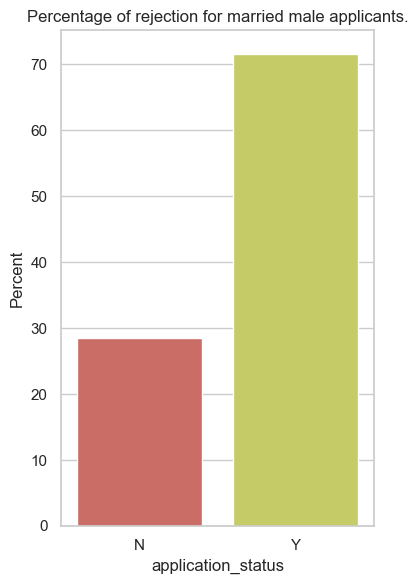

In [28]:
# 5.2 Find the percentage of rejection for married male applicants.

def married_applicants_5_2(pd_df):

  query6 = "(SELECT application_status, COUNT(application_status) AS count_applications, \
		(round(count(application_status)/(SELECT COUNT(*) FROM cdw_sapp_loan_application \
		WHERE Gender = 'Male' AND Married = 'Yes' )*100,2)) AS Percent \
		FROM cdw_sapp_loan_application \
		WHERE Gender = 'Male' AND Married = 'Yes' \
		GROUP BY application_status) as a"

  spark_df = spark.read.format("jdbc") \
  .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
  .option("user", "root") \
  .option("password", "password") \
  .option("dbtable", query6) \
  .load()

  spark_df.show()

  pd_df = spark_df.toPandas()

# pd_sql1.reset_index(inplace=True)
  pd_df['Percent'] = pd_df['Percent'].astype('float')
  print(pd_df.dtypes)

  # pd_df.plot(kind='bar', x='application_status', y='Percent', figsize=(4,6))
  plt.title('The percentage of Applicants rejected/approved')
  plt.xlabel('Application Status')
  plt.ylabel('Percentage of Married Male Applicants')
  sns.set(rc={"figure.figsize":(4,4)})
  sns.set_theme(style="whitegrid", palette="hls")
  sns.barplot(x ='application_status',
            y='Percent',
            data=pd_df).set(title ="Percentage of rejection for married male applicants.")
  plt.show()

married_applicants_5_2('pd_df')

In [30]:
# 5.3 Find and plot the top three months with the largest transaction data.
# Note: Take a screenshot of the graph.

def largest_transactions_5_3(df):
    spark_df = spark.createDataFrame(df)
    spark_df = spark_df.select('TIMEID', 'TRANSACTION_VALUE')
    panda_df = spark_df.toPandas()
    panda_df["month"] = pd.to_datetime(panda_df["TIMEID"], format='%Y%m%d').dt.month
    print(panda_df['month'])

    df_months = panda_df.groupby('month')['TRANSACTION_VALUE'].sum().reset_index()
    print(df_months)
    df_months = df_months.sort_values(by=['TRANSACTION_VALUE'], ascending=False)
    df_months = df_months[:3]
    df_months = df_months.sort_values(by=['month'], ascending=True)
    print(df_months)
    plt.rcParams["figure.figsize"] = [8, 5]
    plt.rcParams["figure.autolayout"] = True
    x = ['May', 'Oct', 'Dec']
    default_x_ticks = range(len(x))
    sns.set_theme(style="whitegrid", palette="hls")
    plt.plot(default_x_ticks, df_months['TRANSACTION_VALUE'], ls='dashed', c='purple', lw='3', marker='o', markerfacecolor='black')
    # supported values are '-', '--', '-.', ':', 'None', ' ', '', 'solid', 'dashed', 'dashdot', 'dotted'
    plt.title('Top Three Months With Highest Number Of Transactions')
    plt.xticks(default_x_ticks, x)
    plt.ylabel('Transaction Amount')
    plt.xlabel('Months')
    plt.show()
    
credit_card_df = get_credit_card_df()
largest_transactions_5_3(credit_card_df)

C:\Users\Learner_XZHCG217\AppData\Local\Temp\ipykernel_6680\3010175532.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return psql.read_sql(query1, con=connection)
C:\Spark\python\pyspark\sql\pandas\conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
C:\Spark\python\pyspark\sql\pandas\conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


+-----------+-----------------------+
|branch_code|Total_Transaction_Value|
+-----------+-----------------------+
|         25|                8740.36|
|         60|                8144.08|
|         83|                8006.74|
|         36|                7647.74|
|        111|                7440.54|
+-----------+-----------------------+

branch_code                  int64
Total_Transaction_Value    float64
Transaction_value          float64
dtype: object


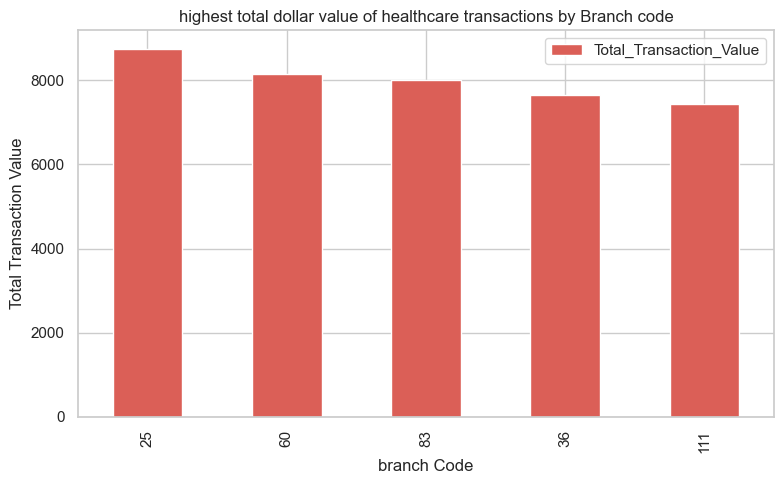

In [ ]:
# 5.4 Find and plot which branch processed the highest total dollar value of healthcare transactions.

def highest_healthcare_transactions_5_4(pandas_df):
  query4 = "(SELECT branch_code, round(SUM(transaction_value),2) AS Total_Transaction_Value  \
            FROM cdw_sapp_credit_card \
            WHERE transaction_type = 'Healthcare'\
            group by branch_code \
            ORDER BY SUM(transaction_value) DESC \
            LIMIT 5) as a"

  spark_df = spark.read.format("jdbc") \
  .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
  .option("user", "root") \
  .option("password", "password") \
  .option("dbtable", query4) \
  .load()

  spark_df.show()
  pandas_df = spark_df.toPandas()

  pandas_df['Transaction_value'] = pandas_df['Total_Transaction_Value'].astype('float')
  print(pandas_df.dtypes)

  pandas_df.plot(kind='bar', x='branch_code', y='Total_Transaction_Value', figsize=(8,5))
  plt.title('highest total dollar value of healthcare transactions by Branch code')
  plt.ylabel('Total Transaction Value')
  plt.xlabel('branch Code')
  plt.show()

highest_healthcare_transactions_5_4('pandas_df')

+-----------+----------------+---------+--------------+----------------+-----------------+--------+
|BRANCH_CODE|      CUST_CC_NO| CUST_SSN|TRANSACTION_ID|TRANSACTION_TYPE|TRANSACTION_VALUE|  TIMEID|
+-----------+----------------+---------+--------------+----------------+-----------------+--------+
|        156|4210653312478046|123455692|         22562|         Grocery|            91.08|20180813|
+-----------+----------------+---------+--------------+----------------+-----------------+--------+
only showing top 1 row



C:\Users\Learner_XZHCG217\AppData\Local\Temp\ipykernel_9228\2160869036.py:20: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_transaction = pd_credVisual[['TRANSACTION_TYPE', 'TRANSACTION_VALUE']].groupby(pd_credVisual['TRANSACTION_TYPE']).sum()
c:\Users\Learner_XZHCG217\Desktop\TEK-Dataengineering\Git\Capstone\capstone_environment\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


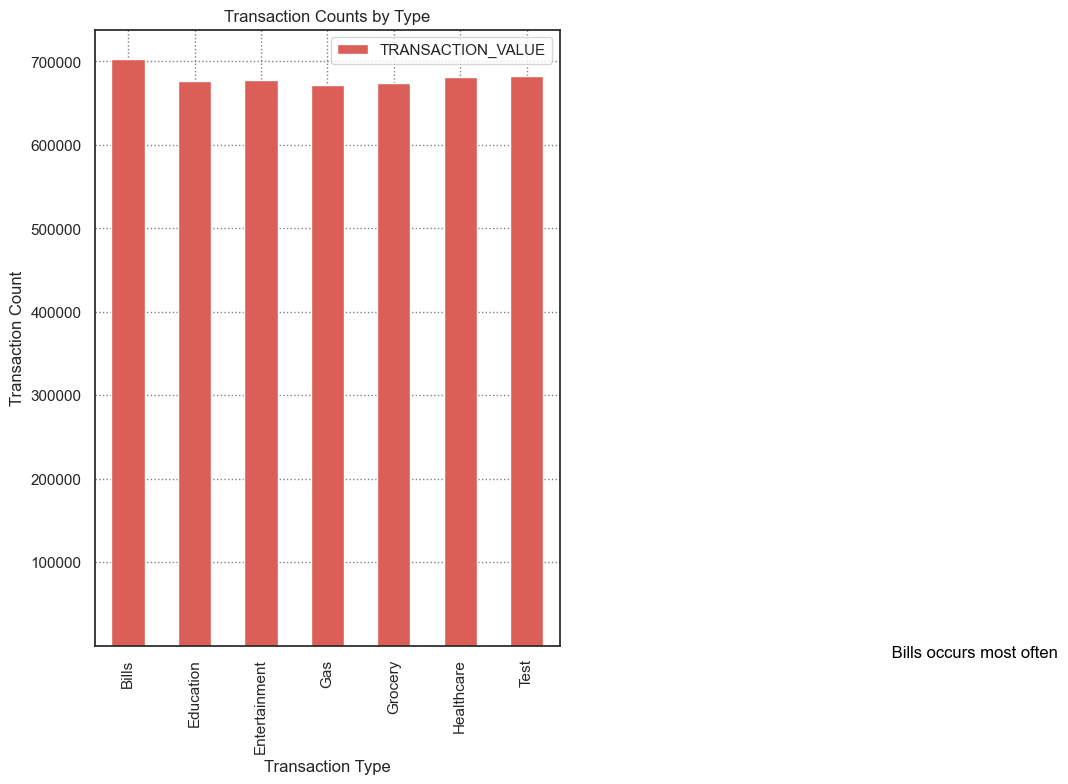

In [ ]:
# 3.1 Find and plot which transaction type has a high rate of transactions

def highest_transaction_type_3_1(df):

    sp_credVisual = spark.read.format("jdbc") \
                    .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
                    .option("dbtable", "cdw_sapp_credit_card") \
                    .option("user", "root") \
                    .option("password", "password") \
                    .load()

    sp_credVisual.show(1)

    # Convert Spark dataframe to Pandas Dataframe
    pd_credVisual = sp_credVisual.toPandas()

    # Display last 5 rows in pandas dataframe
    pd_credVisual.tail()

    df_transaction = pd_credVisual[['TRANSACTION_TYPE', 'TRANSACTION_VALUE']].groupby(pd_credVisual['TRANSACTION_TYPE']).sum()
    df_transaction.reset_index(inplace=True)
    df_transaction.head()

    df_transaction .plot(kind='bar', x='TRANSACTION_TYPE', y='TRANSACTION_VALUE', figsize = (6,8))
    plt.title('Transaction Counts by Type')
    plt.xlabel('Transaction Type')
    plt.ylabel('Transaction Count')
    #supported values are '-', '--', '-.', ':', 'None', ' ', '', 'solid', 'dashed', 'dashdot', 'dotted'
    plt.grid(True, linewidth= 1, linestyle=":", color= 'grey')
    # plt.plot(df_transaction['TRANSACTION_TYPE'].value_counts(), c='purple', marker='o')
    plt.yticks([100000, 200000, 300000, 400000, 500000, 600000, 700000])
    plt.text(14, 0,' Bills occurs most often', fontsize=12,
             color='black', ha='right', va='top',
             alpha=1.0)
    plt.show()

highest_transaction_type_3_1('df_transaction')

C:\Users\Learner_XZHCG217\AppData\Local\Temp\ipykernel_9228\2822380080.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return psql.read_sql(query2, con=connection)
C:\Spark\python\pyspark\sql\pandas\conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


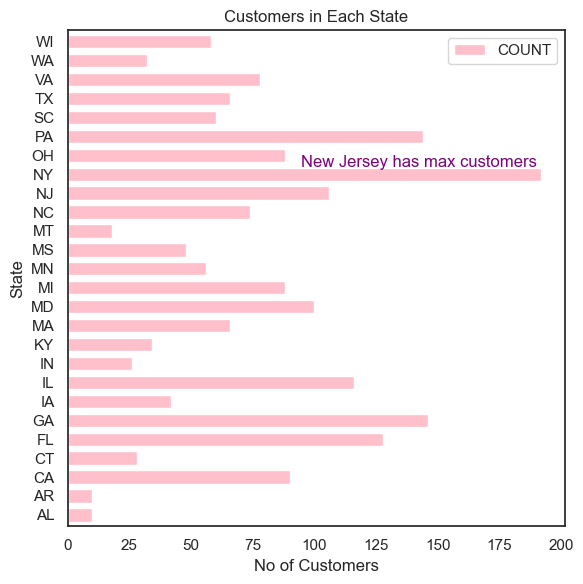

In [100]:
# 3.2 Find and plot which state has a high number of customers.

def highest_number_customer_3_2(customer_df):

    sp_custVisual = spark.read.format("jdbc") \
                    .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
                    .option("dbtable", "cdw_sapp_customer") \
                    .option("user", "root") \
                    .option("password", "password") \
                    .load()

    # Convert Spark dataframe to Pandas Dataframe
    pd_custVisual = sp_custVisual.toPandas()

    # Display last 5 rows in pandas dataframe
    pd_custVisual.tail()

    df_customers = pd_custVisual[['CUST_STATE']].groupby(pd_custVisual['CUST_STATE']).count()
    df_customers.rename(columns = {'CUST_STATE':'COUNT'}, inplace = True)

    df_customers.reset_index(inplace=True)
    df_customers

    df_customers.plot(kind='barh', x='CUST_STATE', y='COUNT', figsize=(6,6), width=0.7, color='pink' )
    plt.title('Customers in Each State')
    plt.xlabel('No of Customers')
    plt.ylabel('State')
    # style must be one of white, dark, whitegrid, darkgrid, ticks
    sns.set_theme(style="white", palette="hls")
    plt.grid(True, linewidth= 1, linestyle="-", color= 'white')
    plt.text(190, 19, 'New Jersey has max customers', fontsize=12,
             color='purple', ha='right', va='top',
             alpha=1.0)
    plt.show()

customer_df = get_customer_df()
highest_number_customer_3_2(customer_df)

C:\Users\Learner_XZHCG217\AppData\Local\Temp\ipykernel_6680\2356337116.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return psql.read_sql(query3, con=connection)
C:\Spark\python\pyspark\sql\pandas\conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
C:\Spark\python\pyspark\sql\pandas\conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


              SSN FIRST_NAME LAST_NAME  TRANSACTION_VALUE
0       123455692    Maurice     Ramey              91.08
1       123455692    Maurice     Ramey              91.08
2       123451310        Del  Madrigal              77.79
3       123451310        Del  Madrigal              77.79
4       123459988     Amalia    Campos              78.90
...           ...        ...       ...                ...
186771  123455692    Maurice     Ramey              76.24
186772  123455692    Maurice     Ramey              81.56
186773  123455692    Maurice     Ramey              81.56
186774  123455692    Maurice     Ramey              81.30
186775  123455692    Maurice     Ramey              81.30

[186776 rows x 4 columns]
    FIRST_NAME  TRANSACTION_VALUE
0         Abby           13087.76
1        Abdul           10994.84
2         Abel            6773.28
3         Adam            8518.08
4        Addie           32104.44
..         ...                ...
766      Young            2255.20
767  

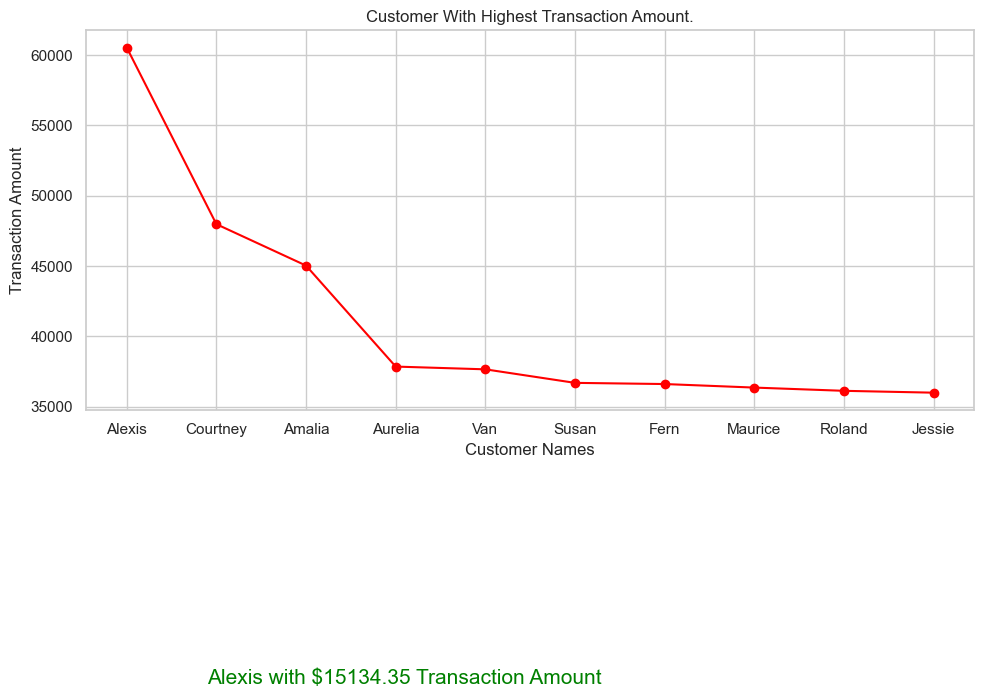

In [18]:
# 3.3 - Find and plot the sum of all transactions for each customer, and which customer has the highest transaction amount.
# hint(use CUST_SSN).

def highest_transaction_amount_3_3(df):

    spark_df = spark.createDataFrame(df)
    spark_df = spark_df.select('SSN', 'FIRST_NAME', 'LAST_NAME', 'TRANSACTION_VALUE')
    pandas_df = spark_df.toPandas()
    print(pandas_df)
    pandas_df = pandas_df.groupby('FIRST_NAME')['TRANSACTION_VALUE'].sum().reset_index()
    print(pandas_df)
    pandas_df = pandas_df.sort_values(by=['TRANSACTION_VALUE'], ascending=False)
    print(pandas_df)
    pandas_df = pandas_df[:10]
    plt.rcParams["figure.figsize"] = [10, 10]
    plt.rcParams["figure.autolayout"] = True
    plt.plot(pandas_df['FIRST_NAME'], pandas_df['TRANSACTION_VALUE'], ls='-', c='red', marker='o')
    plt.xticks(pandas_df['FIRST_NAME'])
    plt.title('Customer With Highest Transaction Amount.')
    plt.text(0.9, 15000, 'Alexis with $15134.35 Transaction Amount', fontsize=15,
             color='green', ha='left', va='bottom',
             alpha=1.0)
    plt.ylabel('Transaction Amount')
    plt.xlabel('Customer Names')

    plt.show()

high_transaction = get_highest_transaction()    
highest_transaction_amount_3_3(high_transaction)
